# Generate Time Series

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import tensorflow.keras as keras



# Create time series - number of time series = batch size
# n_steps = number of steps
# freq and offsets - randomly generated and used in the sinusoidal function

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # noise
    return series[:, np.newaxis].astype(np.float32).reshape(batch_size, n_steps,1)


<AxesSubplot:>

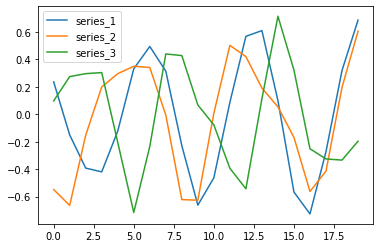

In [2]:
# Let us try to visualise the time series, for simplicity sake just look at 3 stime series
# generate sample 

batch_size = 3
s = generate_time_series(batch_size, 20)

times_df = pd.DataFrame(s.reshape(batch_size,-1)).T
times_df.columns= ['series_' + str(x) for x in range(1,batch_size + 1)]
times_df.plot.line()



# Modelling 

In [8]:
# We will randomly generate 10000 series
# You can think of this as time series of 10000 stocks (We will be actually doing that too)
# X_Train contains 7000 time series of shape 7000,50,1
# X_Valid contains 2000 time series
# X_Test contains 1000 time series 

# X is the first n_steps and we are trying to predict n+1 step
# Y is a column vector, the 51st step -> -1 implies select last column

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

### Baseline Metrics

In [4]:
# Naive - the last value of X_valid

y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.02095118

In [15]:
# simple RNN 

model = keras.models.Sequential([
keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(1e-4), metrics = ['RootMeanSquaredError'])

history = model.fit(x=X_train, y=y_train, batch_size=32,epochs=15, validation_data=(X_valid, y_valid))

Epoch 1/15
219/219 [==============================] - 2s 5ms/step - loss: 0.0237 - root_mean_squared_error: 0.1541 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1501
Epoch 2/15
219/219 [==============================] - 1s 5ms/step - loss: 0.0214 - root_mean_squared_error: 0.1464 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1436
Epoch 3/15
219/219 [==============================] - 1s 5ms/step - loss: 0.0197 - root_mean_squared_error: 0.1405 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1382
Epoch 4/15
219/219 [==============================] - 1s 4ms/step - loss: 0.0184 - root_mean_squared_error: 0.1355 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1337
Epoch 5/15
219/219 [==============================] - 1s 4ms/step - loss: 0.0172 - root_mean_squared_error: 0.1313 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1297
Epoch 6/15
219/219 [==============================] - 1s 4ms/step - loss: 0.0163 - root_mean_squared_error: 0.1276 - val_loss: 0.0159 - val_

In [16]:
# benchmark mse
y_pred = model.predict(X_valid)
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.011762329

In [17]:
y_pred = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

0.011447039

# Deep RNN

In [19]:
# since multiple layers, we can run for more epochs 

model = keras.models.Sequential([
keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,
1]),
keras.layers.SimpleRNN(20, return_sequences=True),
keras.layers.SimpleRNN(1)
])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(1e-4), metrics = ['mean_squared_error'])

history = model.fit(x=X_train, y=y_train, batch_size=32,epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
219/219 [==============================] - 5s 17ms/step - loss: 0.0904 - root_mean_squared_error: 0.3007 - val_loss: 0.0514 - val_root_mean_squared_error: 0.2267
Epoch 2/50
219/219 [==============================] - 3s 15ms/step - loss: 0.0374 - root_mean_squared_error: 0.1934 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1675
Epoch 3/50
219/219 [==============================] - 3s 15ms/step - loss: 0.0218 - root_mean_squared_error: 0.1478 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1301
Epoch 4/50
219/219 [==============================] - 3s 16ms/step - loss: 0.0139 - root_mean_squared_error: 0.1177 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074
Epoch 5/50
219/219 [==============================] - 4s 17ms/step - loss: 0.0099 - root_mean_squared_error: 0.0995 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0935
Epoch 6/50
219/219 [==============================] - 3s 16ms/step - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0070 

In [20]:
# benchmark mse
y_pred = model.predict(X_valid)
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.0027517586

In [21]:
y_pred = model.predict(X_test)
np.mean(keras.losses.mean_squared_error(y_test, y_pred))

0.0025249114

## Forecasting ahead

### method 1 : Treat the new x_pred as input and output the next step recursively


In [42]:
# forecast is the number of steps we want to forecast ahead

forecast = 50
series = generate_time_series(1, n_steps + forecast)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(forecast):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n_steps:]

<AxesSubplot:>

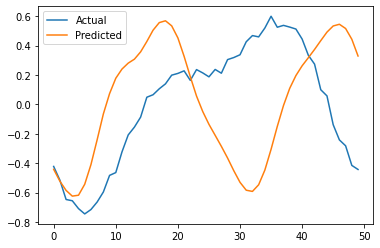

In [43]:
# As we can see, errors keep accumulating, after step 10 pretty poor output

times_df = pd.DataFrame(np.hstack((Y_new.reshape(-1, 1), Y_pred.reshape(-1, 1))), columns = ['Actual','Predicted'])

times_df.plot.line()

### Method 2: Use sequence to vector model

Predict all 50 values at once

In [88]:
# now Y is not a column vector, it consists of all forecasted outputs

forecast = 10
series = generate_time_series(10000, n_steps + forecast)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -forecast:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -forecast:,0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -forecast:, 0]


In [89]:
Y_train.shape

(7000, 10)

In [90]:
model = keras.models.Sequential([
keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,
1]),
keras.layers.SimpleRNN(20),
keras.layers.Dense(forecast)
])

In [91]:
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(1e-4), metrics = ['mean_squared_error'])

history = model.fit(x=X_train, y=Y_train, batch_size=32,epochs=50, validation_data=(X_valid, Y_valid))

Epoch 1/50
219/219 [==============================] - 4s 13ms/step - loss: 0.2003 - mean_squared_error: 0.2003 - val_loss: 0.1046 - val_mean_squared_error: 0.1046
Epoch 2/50
219/219 [==============================] - 3s 12ms/step - loss: 0.0794 - mean_squared_error: 0.0794 - val_loss: 0.0618 - val_mean_squared_error: 0.0618
Epoch 3/50
219/219 [==============================] - 3s 12ms/step - loss: 0.0534 - mean_squared_error: 0.0534 - val_loss: 0.0473 - val_mean_squared_error: 0.0473
Epoch 4/50
219/219 [==============================] - 3s 12ms/step - loss: 0.0442 - mean_squared_error: 0.0442 - val_loss: 0.0417 - val_mean_squared_error: 0.0417
Epoch 5/50
219/219 [==============================] - 3s 12ms/step - loss: 0.0395 - mean_squared_error: 0.0395 - val_loss: 0.0377 - val_mean_squared_error: 0.0377
Epoch 6/50
219/219 [==============================] - 3s 13ms/step - loss: 0.0360 - mean_squared_error: 0.0360 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 7/50
219/219 [==

### Method 3 : Treating Y as a sequence

In [101]:
# forecast_steps is the number of steps you want to forecast ahead, and in this case also the steps ahead you want for y at each step 
forecast_steps = 10
Y = np.empty((10000, n_steps, forecast_steps)) # each target is a sequence of 10D vectors
for step_ahead in range(1, forecast_steps + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps,0]
    Y_train = Y[:7000]
    Y_valid = Y[7000:9000]
    Y_test = Y[9000:]

In [102]:
print(Y_train.shape)
print(Y_valid.shape)
print(Y_test.shape)

(7000, 50, 10)
(2000, 50, 10)
(1000, 50, 10)


In [108]:
# only the last output is used for evaluation (the other outputs are used for training)
Y_test[:, -1].shape

(1000, 10)

In [109]:
model = keras.models.Sequential([
keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,
1]),
keras.layers.SimpleRNN(20, return_sequences=True),
keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(x=X_train, y=Y_train, batch_size=32,epochs=50, validation_data=(X_valid, Y_valid))

C:\Users\91760\anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
219/219 [==============================] - 4s 12ms/step - loss: 0.0493 - last_time_step_mse: 0.0380 - val_loss: 0.0392 - val_last_time_step_mse: 0.0227
Epoch 2/50
219/219 [==============================] - 3s 11ms/step - loss: 0.0375 - last_time_step_mse: 0.0248 - val_loss: 0.0323 - val_last_time_step_mse: 0.0204
Epoch 3/50
219/219 [==============================] - 2s 10ms/step - loss: 0.0327 - last_time_step_mse: 0.0201 - val_loss: 0.0298 - val_last_time_step_mse: 0.0187
Epoch 4/50
219/219 [==============================] - 2s 10ms/step - loss: 0.0292 - last_time_step_mse: 0.0171 - val_loss: 0.0276 - val_last_time_step_mse: 0.0159
Epoch 5/50
219/219 [==============================] - 2s 10ms/step - loss: 0.0263 - last_time_step_mse: 0.0137 - val_loss: 0.0248 - val_last_time_step_mse: 0.0124
Epoch 6/50
219/219 [==============================] - 2s 11ms/step - loss: 0.0236 - last_time_step_mse: 0.0107 - val_loss: 0.0230 - val_last_time_step_mse: 0.0105
Epoch 7/50
219/219 [==